# Group 159 - 🐥 *(Front-Facing Baby Chick emoji)*
## Long Note
Šimon Prasek - 105773
Karel Poncar - 105236
Miroslav Matějček - 105672

In this notebook you fan find all the methods we used. We tried few using a sklearn and then AutoML H2O. The ones using sklearn are trained on dataset X_train_observed and then crossvalidated on X_train_estimated. H2O is using sklearn function for splitting the dataset to training and testing part.

This crossvalidation is tried just on dataset A. Then the solution with the lowest mean absolute error (MAE) is chosen and used for the other datasets.

In [1]:
%load_ext autoreload

In [17]:
%autoreload

# load libraries
import pandas as pd
import numpy as np
import h2o
import sklearn
import matplotlib 
import datetime


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from h2o.automl import H2OAutoML



# 1. Random guess

In [ ]:
y_train = pd.read_parquet("../../dataset/A/train_targets.parquet")
X_train_observed = pd.read_parquet("../../dataset/A/X_train_observed.parquet")
X_train_estimated = pd.read_parquet("../../dataset/A/X_train_estimated.parquet")
X_test = pd.read_parquet("../../dataset/A/X_test_estimated.parquet")
min_production = y_train["pv_measurement"].min()        # min_production = 0 of course
max_production = y_train["pv_measurement"].max()
print(min_production, max_production)
num_rows = 3 * 30 * 24      # num_locations * num_days_to_forecast * num_hours_in_day
data = {'prediction': np.random.rand(num_rows) * (max_production - min_production) + min_production}
df = pd.DataFrame(data)
df.to_csv("random_guess.csv", index_label="id")

In [22]:
# 2. Few regression types

In [18]:
# read dataset A
# for simplicity, We use X_train_estimated as test data for cross validation
y = pd.read_parquet("../../dataset/A/train_targets.parquet")
X_train = pd.read_parquet("../../dataset/A/X_train_observed.parquet")
X_test = pd.read_parquet("../../dataset/A/X_train_estimated.parquet")

In [19]:
def preprocess_train_data(X: pd.DataFrame, y: pd.DataFrame, *args: [str]):
    """
    Usage: preprocess_data(X, y, "everything")
    :param X: features, data from either X_train_observed.parquet or X_train_estimated
    :param y: targets, data from train_targets.parquet
    :param args: how do you want to modify X, y
    :return: preprocessed X, y
    """
    if "everything" in args:
        args = ["align times", "drop 'times' column in y", "remove 'date calc' column", "split 'date forecast'",
                "replace NaNs for zeros"]
    if "align times" in args:
        # several times misalignments, including:
        #       different starting and ending time
        #       y is energy production every hour, but X is weather every 15 minutes
        X = X[X['date_forecast'].isin(y['time'])].reset_index(drop=True)
        y = y[y['time'].isin(X['date_forecast'])].reset_index(drop=True)
        assert X.shape[0] == y.shape[0], f"X.shape = {X.shape}, y.shape = {y.shape}"
    if "drop 'times' column in y" in args:
        # we want to predict power usage, no need to have timestamp in "y"
        y.drop('time', axis=1, inplace=True)
    if "remove 'date calc' column" in args:
        # IMO date of forecast calculation is irrelevant for our predictions
        if 'date_calc' in X:
            X.drop(labels='date_calc', axis=1, inplace=True)
    if "split 'date forecast'":
        # split date forecast into more relevant features - day of the year and time of the day
        X['day_of_year'] = X['date_forecast'].apply(lambda x: x.dayofyear)
        X['hour_of_day'] = X['date_forecast'].apply(lambda x: x.hour)
        X.drop('date_forecast', axis=1, inplace=True)
    if "replace NaNs for zeros":
        # there are NaNs in X (e.g. feature "snow_density"), replace them for zeros
        X.fillna(0, inplace=True)
    return X, y


def preprocess_test_data(X: pd.DataFrame, *args: [str]):
    """
    Usage: preprocess_test_data(X, "everything")
    :param X: features, data from X_train_observed.parquet concatenated with X_train_estimated
    :param args: how do you want to modify X
    :return: preprocessed X
    """
    # function similar to "preprocess_train_data", but it does not receive y
    start_time = X['date_forecast'].iloc[0]
    end_time = X['date_forecast'].iloc[-1] + datetime.timedelta(hours=1)
    time_range = pd.date_range(start=start_time, end=end_time, freq="1H")
    y_temp = pd.DataFrame({'time': time_range, 'pv_measurement': 0})

    X, _ = preprocess_train_data(X, y_temp, *args)
    return X

In [20]:
# edit data
X_train, y_train = preprocess_train_data(X_train, y, "everything")
X_test, y_test = preprocess_train_data(X_test, y, "everything")

In [21]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")


X_train.shape = (29667, 47)
X_test.shape = (4394, 47)
y_train.shape = (29667, 1)
y_test.shape = (4394, 1)


## Machine learning methods

In [5]:
# Decision tree
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)

mae_tree = np.mean(np.abs(np.array(y_test) - y_pred_tree))
mae_tree  # = 616.575890061115

619.5454603900835

In [6]:
# Random forest
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, y_train.values.ravel()) # ravel part is because of scikit's data conversion warning, it does not have to be there
y_pred_forest = random_forest.predict(X_test)

mae_forest = np.mean(np.abs(np.array(y_test) - y_pred_forest))
mae_forest  # = 599.9553060312836

600.4268668725019

In [7]:
# Gradient boosting
gradient_boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1) 
gradient_boosting.fit(X_train, y_train.values.ravel())
y_pred_grad = gradient_boosting.predict(X_test)

mae_grad = np.mean(np.abs(np.array(y_test) - y_pred_grad))
mae_grad    # = 592.2928322998536

592.2928322998533

In [8]:
# Elastic net
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train.values.ravel())
y_pred_elast_net = elastic_net.predict(X_test)

mae_elast_net = np.mean(np.abs(np.array(y_test) - y_pred_elast_net))
mae_elast_net   # = 599.946498024572

/home/mirek/miniconda3/envs/solar-energy-production/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.684e+09, tolerance: 4.240e+06
  model = cd_fast.enet_coordinate_descent(


599.9464980245718

In [9]:
# Support vector regression
svr_model = SVR(kernel='rbf', C=1.)
svr_model.fit(X_train, y_train.values.ravel())
y_pred_svr = svr_model.predict(X_test)

mae_svr = np.mean(np.abs(np.array(y_test) - y_pred_svr))
mae_svr # = 473.76274242555763

473.76274242555763

In [10]:
# Hyperparameter tuning of SVR
# no need to run this section, it takes too long; the results are approx.: 
# [345, 362, 397, 437, 473, 497, 513] 
# lower C gives us better results
for C in [0.001, 0.03, 0.1, 0.3, 1, 3, 10]:
    svr_model = SVR(kernel='rbf', C=C)
    svr_model.fit(X_train, y_train.values.ravel())
    y_pred_svr = svr_model.predict(X_test)

    print(np.mean(np.abs(np.array(y_test) - y_pred_svr)), end=", ")

345.1870758178765, 362.3174570223702, 397.974746466719, 437.0422504854231, 473.76274242555763, 497.00397971674676, 513.0037055004162, 

# Prediction on real test data


Usage of Support Vector Regression on data sets A,B,C.

In [12]:
# Support Vector Regression
prediction = []

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    # preprocess the data
    X_train, y_train = data_preprocess.preprocess_train_data(X_train, y_train, "everything")
    X_test = data_preprocess.preprocess_test_data(X_test, "everything")
    # learn 
    model = SVR(kernel='rbf', C=.001)
    model.fit(X_train, y_train.values.ravel())
    prediction = np.concatenate((prediction, model.predict(X_test)))
prediction[prediction < 0.] = 0. # energy production can't be negative
df = pd.DataFrame({'prediction': prediction})
df.to_csv('svr.csv', index_label='id')
print("done")

dataset A
dataset B
dataset C
done


# 3. AutoML

In [11]:
#H2O AutoML

X = pd.concat([
    pd.read_parquet("../../dataset/A/X_train_observed.parquet"),
    pd.read_parquet("../../dataset/A//X_train_estimated.parquet")
], ignore_index=True)
y = pd.read_parquet("../../dataset/A//train_targets.parquet")

X_y_bacon = X.merge(y, left_on = "date_forecast", right_on = "time")
X_y_bacon = X_y_bacon.dropna(subset = "pv_measurement")

columns_to_drop = ["snow_drift:idx", "elevation:m", 'snow_melt_10min:mm', 'fresh_snow_12h:cm',
                   'fresh_snow_3h:cm',  'fresh_snow_6h:cm', 'wind_speed_w_1000hPa:ms', 
                   'snow_water:kgm2', 'snow_density:kgm3', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 
                   'wind_speed_v_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_10m:ms',
                   'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'dew_or_rime:idx', 
                   'date_forecast', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J', 
                   'dew_point_2m:K','super_cooled_liquid_water:kgm2', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'prob_rime:p','date_forecast']   

X_y_bacon.drop(columns=columns_to_drop+['time'], inplace=True)

train,test = sklearn.model_selection.train_test_split(X_y_bacon, test_size = 0.20)

h2o.init(max_mem_size = "16G") # If u have more RAM change the parameter

train_frame = h2o.H2OFrame(train)
test_frame = h2o.H2OFrame(test)

x = train_frame.columns[:-1] 
y = train_frame.columns[-1] 

aml = H2OAutoML(max_runtime_secs = 60,
                sort_metric = "MAE",
                stopping_metric = "MAE",
                seed = 7213712285)
aml.train(x = x, 
          y = y,
          training_frame = train_frame,
          validation_frame = test_frame)

print(aml.leaderboard)
best_model = aml.get_best_model(criterion='MAE')

h2o.shutdown()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 15 mins
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_mirek_0utjor
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.96 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:11:29.145: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     mae     rmse     mse       rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_5_20231112_151129     195.439  436.035  190127  nan                           190127
StackedEnsemble_BestOfFamily_2_AutoML_5_20231112_151129  197.03   437.359  191283  nan                           191283
GBM_3_AutoML_5_20231112_151129                           197.43   439.29   192976 

/tmp/ipykernel_50730/618429429.py:44: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


Usage of H2O AutoML on data sets A,B,C. There are few versions. We figured out some work better than the others.

# H2O with data preprocess - remove NaNs, columns (V1)


In [13]:
# H2O with data preprocess - remove NaNs, columns (V1)

all_predictions = pd.DataFrame()
# Init of H2O
h2o.init(max_mem_size = "16G") # If u have more RAM change the parameter

for letter in ['A', 'B', 'C']:
    # Load data
    print(f"dataset {letter}")
    # Load data from Parquet files and concatenate them into a single DataFrame 'X'
    X = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    
    # Preprocess the data
    
    # Merge DataFrame 'X' and 'y' based on the common column "date_forecast"
    X_y_bacon = X.merge(y, left_on = "date_forecast", right_on = "time")
    
    # Remove rows with missing values in the "pv_measurement" variable
    X_y_bacon = X_y_bacon.dropna(subset = "pv_measurement")
    X_y_bacon.drop(columns=['time'], inplace=True)
    
    # List of columns to be dropped
   
    columns_to_drop = ["snow_drift:idx", "elevation:m", 'snow_melt_10min:mm','fresh_snow_12h:cm',
                       'fresh_snow_3h:cm',  'fresh_snow_6h:cm', 'wind_speed_w_1000hPa:ms', 
                       'snow_water:kgm2', 'snow_density:kgm3', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 
                       'wind_speed_v_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_10m:ms',
                       'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'dew_or_rime:idx', 
                       'date_forecast', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J', 
                       'dew_point_2m:K','super_cooled_liquid_water:kgm2', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'prob_rime:p','date_forecast']   
    
    
    # Remove specified columns from training data
    X_y_bacon.drop(columns=columns_to_drop+['time'], inplace=True)
    
    # Load test data and remove specified columns
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    X_test = X_test.iloc[::4]
    X_test.drop(columns=columns_to_drop, inplace=True)
    x_test = h2o.H2OFrame(X_test)

    
    # Split data into training and validation frames (80:20)
    train,test = sklearn.model_selection.train_test_split(X_y_bacon, test_size = 0.20)

    train_frame = h2o.H2OFrame(train)
    test_frame = h2o.H2OFrame(test)
    
    x = train_frame.columns[:-1] 
    y = train_frame.columns[-1] 
    
    # Create an AutoML model
    aml = H2OAutoML(max_runtime_secs = 60,
                    sort_metric = "MAE",
                    stopping_metric = "MAE",
                    seed = 7213712285) #7213712285 
    aml.train(x = x, 
              y = y,
              training_frame = train_frame,
              validation_frame = test_frame)
    
    print(aml.leaderboard)
    best_model = aml.get_best_model(criterion='MAE')
    second_best_model = h2o.get_model(h2o.as_list(aml.leaderboard)["model_id"].iloc[1])
    
    # Make predictions on test data and make CSV file
    prediction1 = best_model.predict(x_test)
    predictions1_df = h2o.as_list(prediction1)
    predictions1_df[predictions1_df < 0.] = 0.
        
    all_predictions = pd.concat([all_predictions, predictions1_df], ignore_index=True)
    all_predictions.to_csv('AutoML_H2O-V1.csv', index_label='id')
    print("CSV file updated")

# Explain the best model on the validation frame for model interpretation
best_model.explain(test_frame)

# Shut down H2O
h2o.shutdown()
print("Done")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /home/mirek/miniconda3/envs/solar-energy-production/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpisrug7s4
  JVM stdout: /tmp/tmpisrug7s4/h2o_mirek_started_from_python.out
  JVM stderr: /tmp/tmpisrug7s4/h2o_mirek_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_mirek_6pkjot
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


dataset A


KeyError: "['time'] not found in axis"

# H2O with data preprocess and two predictors (V2)


In [ ]:
# H2O with data preprocess and two predictors (V2)

all_predictions = pd.DataFrame()
# Init of H2O
h2o.init(max_mem_size = "16G") # If u have more RAM change the parameter

for letter in ['A', 'B', 'C']:
    # Load data
    print(f"dataset {letter}")
    # Load data from Parquet files and concatenate them into a single DataFrame 'X'
    X = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    
    # Preprocess the data
    
    # Merge DataFrame 'X' and 'y' based on the common column "date_forecast"
    X_y_bacon = X.merge(y, left_on = "date_forecast", right_on = "time")
    
    # Remove rows with missing values in the "pv_measurement" variable
    X_y_bacon = X_y_bacon.dropna(subset = "pv_measurement")
    
    # List of columns to be dropped
   
    columns_to_drop = ["snow_drift:idx", "elevation:m", 'snow_melt_10min:mm','fresh_snow_12h:cm',
                       'fresh_snow_3h:cm',  'fresh_snow_6h:cm', 'wind_speed_w_1000hPa:ms', 
                       'snow_water:kgm2', 'snow_density:kgm3', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 
                       'wind_speed_v_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_10m:ms',
                       'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'dew_or_rime:idx', 
                       'date_forecast', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J', 
                       'dew_point_2m:K','super_cooled_liquid_water:kgm2', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'prob_rime:p','date_forecast']   
    
    
    # Remove specified columns from training data
    X_y_bacon.drop(columns=columns_to_drop+['time'], inplace=True)
    
    # Load test data and remove specified columns
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    X_test = X_test.iloc[::4]
    X_test.drop(columns=columns_to_drop, inplace=True)
    x_test = h2o.H2OFrame(X_test)

    
    # Split data into training and validation frames (80:20)
    train,test = sklearn.model_selection.train_test_split(X_y_bacon, test_size = 0.20)

    train_frame = h2o.H2OFrame(train)
    test_frame = h2o.H2OFrame(test)
    
    x = train_frame.columns[:-1] 
    y = train_frame.columns[-1] 
    
    # Create an AutoML model
    aml = H2OAutoML(max_runtime_secs = 60,
                    sort_metric = "MAE",
                    stopping_metric = "MAE",
                    seed = 7213712285) #7213712285
    aml.train(x = x, 
              y = y,
              training_frame = train_frame,
              validation_frame = test_frame)
    
    print(aml.leaderboard)
    best_model = aml.get_best_model(criterion='MAE')
    second_best_model = h2o.get_model(h2o.as_list(aml.leaderboard)["model_id"].iloc[1])
    
    # Make predictions on test data and make CSV file
    prediction1 = best_model.predict(x_test)
    predictions1_df = h2o.as_list(prediction1)
    predictions1_df[predictions1_df < 0.] = 0.
    
    prediction2 = second_best_model.predict(x_test)
    predictions2_df = h2o.as_list(prediction2)
    predictions2_df[predictions2_df < 0.] = 0.

    prediction = (predictions1_df["predict"] + predictions2_df["predict"])/2
    
    all_predictions = pd.concat([all_predictions, prediction], ignore_index=True)
    all_predictions.to_csv('AutoML_H2O-V2.csv', index_label='id')
    print("CSV file updated")

# Explain the best model on the validation frame for model interpretation
best_model.explain(test_frame)

# Shut down H2O
h2o.shutdown()
print("Done")

# H2O without data preprocess - USED IN SHORT NOTE 1

In [23]:
# H2O without data preprocess - USED IN SHORT NOTE (V3)

all_predictions = pd.DataFrame()
# Init of H2O
h2o.init(max_mem_size = "16G") # If u have more RAM change the parameter

for letter in ['A', 'B', 'C']:
    # Load data
    print(f"dataset {letter}")
    # Load data from Parquet files and concatenate them into a single DataFrame 'X'
    X = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    
    # Preprocess the data
    
    # Merge DataFrame 'X' and 'y' based on the common column "date_forecast"
    X_y_bacon = X.merge(y, left_on = "date_forecast", right_on = "time")
    
    # Load test data and remove specified columns
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    X_test = X_test.iloc[::4]
    #X_test.drop(columns=columns_to_drop, inplace=True)
    x_test = h2o.H2OFrame(X_test)

    
    # Split data into training and validation frames (80:20)
    train,test = sklearn.model_selection.train_test_split(X_y_bacon, test_size = 0.20)

    train_frame = h2o.H2OFrame(train)
    test_frame = h2o.H2OFrame(test)
    
    x = train_frame.columns[:-1] 
    y = train_frame.columns[-1] 
    
    # Create an AutoML model
    aml = H2OAutoML(max_runtime_secs = 60,
                    sort_metric = "MAE",
                    stopping_metric = "MAE",
                    seed = 7213712285) 
    aml.train(x = x, 
              y = y,
              training_frame = train_frame,
              validation_frame = test_frame)
    
    print(aml.leaderboard)
    best_model = aml.get_best_model(criterion='MAE')
    
    # Make predictions on test data and make CSV file
    prediction1 = best_model.predict(x_test)
    predictions1_df = h2o.as_list(prediction1)
    predictions1_df[predictions1_df < 0.] = 0.
    
    all_predictions = pd.concat([all_predictions, predictions1_df], ignore_index=True)
    all_predictions.to_csv('AutoML_H2O-V3.csv', index_label='id')
    print("CSV file updated")

# Explain the best model on the validation frame for model interpretation
best_model.explain(test_frame)

# Shut down H2O
h2o.shutdown()
print("Done")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,23 mins 03 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_mirek_6pkjot
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


dataset A
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:39:11.750: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
15:39:11.807: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]
█████████████
15:39:24.957: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]
███
15:39:27.366: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]
 (cancelled)


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_8efa56fa2ad253da3b1bc0fee41a46cb> was cancelled by the user.

# 4. Trying to explain the data

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [33]:
y_train = pd.read_parquet("../../dataset/A/train_targets.parquet")
X_train_observed = pd.read_parquet("../../dataset/A/X_train_observed.parquet")
X_train_estimated = pd.read_parquet("../../dataset/A/X_train_estimated.parquet")
X_test = pd.read_parquet("../../dataset/A/X_test_estimated.parquet")
print(f"Observed {X_train_observed.shape}")
print(f"Estimated {X_train_estimated.shape}")
print(f"y {y_train.shape}")
print(f"Test {X_train_observed.shape}")

Observed (118669, 46)
Estimated (17576, 47)
y (34085, 2)
Test (118669, 46)


There is an extra column in estimated


In [34]:
set(X_train_estimated.columns) ^ set(X_train_observed.columns)

{'date_calc'}

In [35]:
# We shouldn't need date calc at all
X_train_estimated.drop(["date_calc"], axis=1, inplace=True)
X_train_estimated.shape

(17576, 46)

In [36]:
print(y_train.shape[0] * 4)
print(X_train_observed.shape[0] + X_train_estimated.shape[0])
print(y_train.iloc[0,0], y_train.iloc[-1,0])
print(X_train_observed.iloc[0,0], X_train_observed.iloc[-1,0])
print(X_train_estimated.iloc[0,0], X_train_estimated.iloc[-1,0])
print(X_test.iloc[0,0], X_test.iloc[-1,0])

136340
136245
2019-06-02 22:00:00 2023-04-30 23:00:00
2019-06-02 22:00:00 2022-10-21 01:00:00
2022-10-28 22:00:00 2023-04-30 23:45:00
2023-04-30 07:00:04 2023-07-02 07:00:31


The dimensions of X and y does not match.
We have the weather for every 15 minutes, but doing hourly predictions 
We can repeat the lines of y and then we can average the output
Also there are some missing times in X or Y -> we can delete this data

In [37]:
# y_train = y_train.loc[y_train.index.repeat(4)]
# print(y_train.shape)
# for i in range(int(y_train.shape[0] / 4)):
#     y_train.iloc[4*i+1, 0] += pd.Timedelta("15 min")
#     y_train.iloc[4*i+2, 0] += pd.Timedelta("30 min")
#     y_train.iloc[4*i+3, 0] += pd.Timedelta("45 min")

y_train = y_train.loc[y_train.index.repeat(4)].reset_index(drop=True)
y_train['time'] += y_train.groupby(y_train.index // 4).cumcount() * pd.Timedelta("15 min")
y_train = y_train[y_train['time'].isin(X_train_observed['date_forecast']) | y_train['time'].isin(X_train_estimated['date_forecast'])].reset_index(drop=True)      
X_train_observed = X_train_observed[X_train_observed['date_forecast'].isin(y_train['time'])].reset_index(drop=True)
X_train_estimated = X_train_estimated[X_train_estimated['date_forecast'].isin(y_train['time'])].reset_index(drop=True)
print(y_train.shape[0])
print(X_train_observed.shape[0] + X_train_estimated.shape[0])
print(y_train.iloc[0,0], y_train.iloc[-1,0])
print(X_train_observed.iloc[0,0], X_train_observed.iloc[-1,0])
print(X_train_estimated.iloc[0,0], X_train_estimated.iloc[-1,0])

136244
136244
2019-06-02 22:00:00 2023-04-30 23:45:00
2019-06-02 22:00:00 2022-10-21 00:45:00
2022-10-28 22:00:00 2023-04-30 23:45:00


In [38]:
set(X_train_observed.columns[X_train_observed.isna().any()]) & set(X_train_estimated.columns[X_train_estimated.isna().any()].tolist())

{'ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3'}

This columns contains NaNs, we need to fill this data.
How does 'ceiling_height_agl:m', 'cloud_base_agl:m' look like? https://www.meteomatics.com/en/api/available-parameters/alphabetic-list

<Axes: title={'center': 'ceiling_height_agl:m'}, xlabel='date_forecast'>

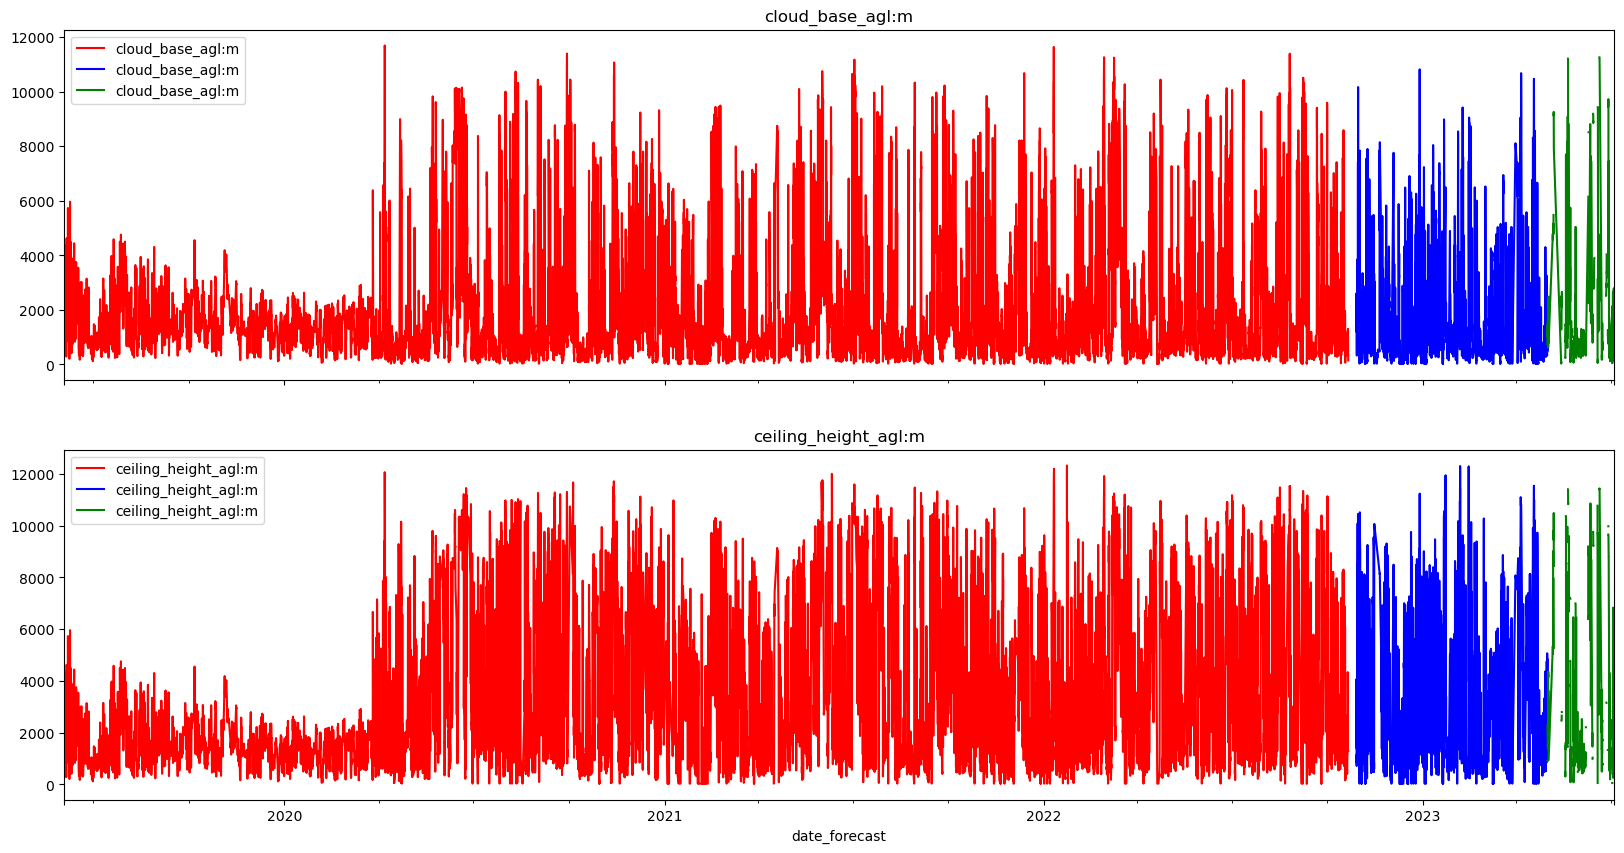

In [43]:
X_train_observed = X_train_observed.interpolate(axis=0)
X_train_estimated = X_train_estimated.interpolate(axis=0)
# Plotting a single feature
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
feature_name = 'cloud_base_agl:m'
X_train_observed[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title=feature_name, color='red')
X_train_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title=feature_name, color='blue')
X_test[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title=feature_name, color='green')

# Plotting a single feature
feature_name = 'ceiling_height_agl:m'
X_train_observed[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title=feature_name, color='red')
X_train_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title=feature_name, color='blue')
X_test[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title=feature_name, color='green')

Let's look to some information about the data

In [44]:
X_train_observed.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,118668,118668.000000,118668.000000,118668.000000,1.186680e+05,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,1.186680e+05,118668.000000,1.186680e+05,118668.000000,118668.0,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,101246.0,118668.000000,118668.0,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000,118668.000000
mean,2021-02-09 23:22:30.000000512,6.652590,1.249064,3247.824951,5.994068e+05,166.501785,1885.553345,0.022399,276.823395,44.918659,1.617070e+05,56.612221,2.038042e+05,67.606071,6.0,0.053118,0.004418,0.106243,0.013277,0.026567,0.521396,0.511646,1009.632874,0.006302,0.091019,996.765381,1002.868164,0.187400,0.011914,74.231613,1008.998291,250.0,0.052763,0.0,0.000062,0.091566,179.630707,1.529839,0.059088,280.708588,74.401695,32446.955078,3.043210,0.756796,0.517433,0.000019
min,2019-06-02 22:00:00,0.700000,1.145000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,250.899994,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,944.299988,0.000000,0.000000,932.299988,938.099976,0.000000,0.000000,22.700001,943.900024,250.0,0.000000,0.0,-0.000000,0.000000,0.002000,-50.004002,0.000000,258.899994,0.000000,154.300003,0.000000,-7.300000,-9.300000,-0.000000
25%,2020-04-06 22:41:15,4.400000,1.224000,1177.275024,0.000000e+00,0.000000,610.900024,0.000000,272.100006,0.000000,0.000000e+00,0.000000,0.000000e+00,43.299999,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1002.099976,0.000000,0.000000,989.299988,995.299988,0.000000,0.000000,65.000000,1001.400024,250.0,0.000000,0.0,-0.000000,0.000000,88.488749,-15.063750,0.000000,275.899994,54.799999,15592.175293,1.700000,-1.400000,-0.700000,0.000000
50%,2021-02-09 23:22:30,6.300000,1.247000,2127.500000,3.574835e+04,8.600000,1226.332153,0.000000,277.200012,4.100000,2.481590e+04,0.000000,8.965000e+01,80.500000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1010.700012,0.000000,0.000000,997.900024,1003.900024,0.000000,0.000000,76.699997,1010.000000,250.0,0.000000,0.0,0.000000,0.000000,179.437500,1.202000,0.000000,280.700012,93.699997,36359.701172,2.700000,0.400000,0.500000,-0.000000
75%,2021-12-16 00:03:45,8.600000,1.272000,4798.299805,1.037838e+06,288.799988,2251.000000,0.000000,282.000000,76.000000,2.743284e+05,41.799999,1.598418e+05,98.800003,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1018.299988,0.000000,0.000000,1005.400024,1011.500000,0.000000,0.000000,85.400002,1017.599976,250.0,0.000000,0.0,0.000000,0.100000,270.641243,18.995001,0.100000,285.200012,99.900002,48084.575195,4.100000,2.700000,1.700000,0.000000
max,2022-10-21 00:45:00,17.500000,1.427000,12328.500000,3.005720e+06,836.400024,11688.700195,1.000000,293.799988,345.700012,1.205498e+06,688.700012,2.451173e+06,100.000000,6.0,15.100000,3.900000,15.100000,7.900000,14.800000,1.000000,1.000000,1044.000000,2.23

We can see that snow_drift:idx are only 0. elevation:m is constant, so we can remove them. 

In [ ]:
X_train_estimated.drop(columns=["snow_drift:idx", "elevation:m"],  inplace=True)
X_train_observed.drop(columns=["snow_drift:idx", "elevation:m"], inplace=True)

We can also remove highly correlated columns. The columns without correlation with the energy production also should not be necessary

In [46]:
display(pd.merge(y_train, X_train_observed.rename(columns={'date_forecast': 'time'}), how="inner", on='time').corr())
with open('correlation.html', 'w') as f: # make it nicer
    print(pd.merge(y_train, X_train_observed.rename(columns={'date_forecast': 'time'}), how="inner", on='time').corr().style.background_gradient()
.to_html(), file=f)


,time,pv_measurement,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
time,1.000000,0.023750,0.025112,0.028651,0.241210,0.019492,0.019403,0.078364,0.004579,0.024157,0.040530,0.041106,-0.004116,-0.004150,0.060254,NaN,0.004816,0.002605,0.006445,0.003241,0.003853,0.019741,-0.022063,0.105696,0.045796,0.159598,0.105865,0.105865,-0.011472,0.038484,0.000851,0.105857,NaN,-0.007365,NaN,-0.037367,-0.000592,0.000829,0.030997,-0.011335,0.002629,0.054884,-0.041891,-0.007045,0.048784,-0.040544,-0.008624
pv_measurement,0.023750,1.000000,0.230557,-0.376005,0.201236,0.797501,0.810095,0.186471,-0.065421,0.245280,0.708439,0.701657,0.860284,0.847485,-0.215947,NaN,-0.048656,-0.032621,-0.063958,-0.040317,-0.046114,0.539194,-0.572735,0.180927,-0.061202,-0.090227,0.181160,0.176168,-0.041395,-0.083963,-0.404427,0.171167,NaN,-0.058203,NaN,-0.018087,-0.135769,-0.015468,0.694605,-0.128140,0.351599,-0.183096,0.258646,-0.081247,-0.065414,-0.278248,-0.005325
absolute_humidity_2m:gm3,0.025112,0.230557,1.000000,-0.804124,0.117993,0.352799,0.349925,0.020243,0.123429,0.974863,0.284845,0.291106,0.239286,0.243771,0.021246,NaN,-0.119009,-0.069180,-0.148715,-0.085106,-0.098864,0.304648,-0.322751,0.147834,0.067723,-0.025244,0.165349,0.154407,-0.055803,0.261639,0.160020,0.143462,NaN,-0.203686,NaN,-0.013563,0.034040,0.022868,0.432341,0.110362,0.900297,0.043028,-0.158685,-0.157922,0.050103,-0.258793,0.004869
air_density_2m:kgm3,0.028651,-0.376005,-0.804124,1.000000,-0.173320,-0.473963,-0.463352,-0.099914,-0.060455,-0.838734,-0.402075,-0.415492,-0.393767,-0.409483,-0.067082,NaN,0.063040,0.044147,0.075156,0.052816,0.058817,-0.386338,0.402329,0.280094,-0.084776,-0.012125,0.263751,0.275650,0.072124,-0.162898,0.141426,0.287480,NaN,0.316893,NaN,0.013984,-0.065669,-0.067947,-0.504496,-0.063594,-0.915071,-0.103030,-0.011078,-0.017519,0.026203,0.142867,-0.000574
ceiling_height_agl:m,0.241210,0.201236,0.117993,-0.173320,1.000000,0.090234,0.084367,0.692072,0.030494,0.108247,0.061956,0.066469,0.277179,0.285477,-0.426620,NaN,-0.021225,-0.012180,-0.028200,-0.016353,-0.018584,0.068675,-0.072672,0.108150,-0.016438,-0.069754,0.112690,0.110015,0.017555,-0.159381,-0.416178,0.107339,NaN,-0.068347,NaN,-0.030074,-0.192262,0.043859,0.097826,-0.341298,0.272599,-0.237106,0.451311,-0.178920,-0.324658,-0.015078,-0.004065
clear_sky_energy_1h:J,0.019492,0.797501,0.352799,-0.473963,0.090234,1.000000,0.992332,0.055436,-0.080024,0.362015,0.911178,0.922412,0.719660,0.732282,0.002803,NaN,-0.056606,-0.037863,-0.072752,-0.046583,-0.052732,0.650793,-0.690136,0.157752,-0.008043,-0.032568,0.160361,0.154128,-0.050701,0.054176,-0.339911,0.147888,NaN,-0.074641,NaN,-0.020593,-0.039221,0.056781,0.847873,0.016901,0.438992,0.009879,0.092575,0.013020,0.069510,-0.343041,-0.005087
clear_sky_rad:W,0.019403,0.810095,0.349925,-0.463352,0.084367,0.992332,1.000000,0.052885,-0.079422,0.359137,0.917221,0.914733,0.727172,0.728481,0.003261,NaN,-0.055062,-0.037589,-0.072561,-0.045966,-0.051830,0.651261,-0.693265,0.158357,-0.009061,-0.032315,0.160652,0.154570,-0.050494,0.052231,-0.313414,0.148477,NaN,-0.074147,NaN,-0.020584,-0.041591,0.002414,0.851638,0.017785,0.424910,0.009635,0.083517,0.003148,0.063866,-0.327926,-0.006878
cloud_base_agl:m,0.078364,0.186471,0.020243,-0.099914,0.692072,0.055436,0.

/home/mirek/miniconda3/envs/solar-energy-production/lib/python3.10/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/mirek/miniconda3/envs/solar-energy-production/lib/python3.10/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


Also lets see, which features would linear regression model use, ass its easy to interpret

In [64]:
X_train_observed = X_train_observed.drop('snow_density:kgm3', axis=1, errors='ignore')
regNorm = LinearRegression().fit(StandardScaler().fit_transform(X_train_observed.drop("date_forecast", axis=1)),
                                 y_train[y_train['time'].isin(X_train_observed['date_forecast'])][
                                     'pv_measurement'].reset_index(drop=True))
regNorm.score(StandardScaler().fit_transform(X_train_observed.drop("date_forecast", axis=1)),
              y_train[y_train['time'].isin(X_train_observed['date_forecast'])]['pv_measurement'].reset_index(drop=True))

resNorm = regNorm.predict(StandardScaler().fit_transform(X_train_observed.drop("date_forecast", axis=1)))


In [65]:
for feature, coef in sorted(zip(X_train_observed.columns, regNorm.coef_), key=lambda x:abs(x[1]), reverse=True):
    print(feature, coef)

is_in_shadow:idx 3327.5059
precip_type_5min:idx -2736.873
pressure_100m:hPa -1259.3734
diffuse_rad_1h:J 764.5216
relative_humidity_1000hPa:p 726.1907
clear_sky_energy_1h:J 458.7129
dew_point_2m:K 309.0916
dew_or_rime:idx 285.4808
super_cooled_liquid_water:kgm2 -228.61453
ceiling_height_agl:m -205.93535
date_forecast -199.37793
absolute_humidity_2m:gm3 -187.74838
direct_rad:W -98.22584
diffuse_rad:W -96.68724
rain_water:kgm2 -34.987564
direct_rad_1h:J -31.039238
visibility:m -28.815456
clear_sky_rad:W 24.348904
sun_elevation:d 22.758453
wind_speed_10m:ms -21.22808
precip_5min:mm -20.856972
total_cloud_cover:p 17.344482
wind_speed_u_10m:ms 14.570972
t_1000hPa:K -13.253044
cloud_base_agl:m 9.2780075
msl_pressure:hPa -9.139694
air_density_2m:kgm3 -7.578888
snow_water:kgm2 7.52141
fresh_snow_1h:cm -6.9774094
sun_azimuth:d 5.4823837
fresh_snow_12h:cm 5.0486145
snow_melt_10min:mm -4.849907
sfc_pressure:hPa 3.7608948
pressure_50m:hPa 2.2160406
is_day:idx 1.93013
prob_rime:p 1.7228394
fresh_sno

Then we did correlation of the parameters and regression. We figured out we are not using wind and snow parameters a lot.
But the snow should be a good indicator of low energy production, we should try to connect its features into one: is_snow 

All the pressure features are really high correlated, so we can use only one of them. I chose the surface pressure

All clear_sky_energy_1h:J and clear_sky_rad:W are also really high correlated, lest drop the 1h value, the same for direct_rad and diffuse_rad

Humidity and dew_point are also highly correlated, and We don't think we need them both, let's drop the dew_point_2m:K 

And We are not sure if super_cooled_liquid_water:kgm2 ceiling_height_agl:m cloud_base_agl:m prob_rime:p can have some impact to energy production, but let's assume they do not 


dew_or_rime:idx is column with 1 for dew and -1 for rime, mby we should split this to two indexes

we should split datetime to year, day and hour

So we made a function:

In [68]:
def preprocess(X):
    """Prepare the data to be used in ML models"""

    # Remove NaNs from snow_density
    X['snow_density:kgm3'] = X['snow_density:kgm3'].fillna(0)
    # Interpolate all other NaNs
    X = X.interpolate(axis=0)

    # Make a new row saying only if there is snow, dew or rhime or not
    def is_snow(row):
        if row['fresh_snow_24h:cm'] > 0 or row['snow_depth:cm'] > 0:
            return 1
        else:
            return 0

    X['is_snow'] = X.apply(is_snow, axis=1)

    def is_dew(row):
        return 1 if row['dew_or_rime:idx'] > 0.1 else 0

    def is_rime(row):
        return 1 if row['dew_or_rime:idx'] < -0.1 else 0

    X['is_dew'] = X.apply(is_dew, axis=1)
    X['is_rime'] = X.apply(is_rime, axis=1)

    # Split the date into separate columns
    X['year'] = X['date_forecast'].apply(lambda x: x.year)
    X['day_of_year'] = X['date_forecast'].apply(lambda x: x.dayofyear)
    X['hour_of_day'] = X['date_forecast'].apply(lambda x: x.hour)

    # Drop columns that seems to be unnecessary
    columns_to_drop = ["snow_drift:idx", "elevation:m", 'snow_melt_10min:mm', 'fresh_snow_12h:cm', 'fresh_snow_3h:cm',
                       'fresh_snow_6h:cm', 'wind_speed_w_1000hPa:ms', 'snow_water:kgm2', 'snow_density:kgm3',
                       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'wind_speed_v_10m:ms', 'wind_speed_u_10m:ms',
                       'wind_speed_10m:ms', 'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa',
                       'dew_or_rime:idx', 'date_forecast', 'clear_sky_energy_1h:J', 'diffuse_rad_1h:J',
                       'direct_rad_1h:J', 'dew_point_2m:K']
    columns_to_drop += ['super_cooled_liquid_water:kgm2', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'prob_rime:p']
    X.drop(columns=columns_to_drop, inplace=True)
    X.drop(["date_calc"], axis=1, inplace=True, errors='ignore')
    X['ones'] = 1
    return X


def make_y_15mins(y):
    """ We have weather data for every 15 min, but energy production data only every hour, so we copy every row 4 times"""
    y = y.loc[y.index.repeat(4)].reset_index(drop=True)
    y['time'] += y.groupby(y.index // 4).cumcount() * pd.Timedelta("15 min")

    y = y.dropna()
    return y


def match_x_and_y(X, y):
    """Take only dates with both weather and pover production data"""
    y = y.dropna()
    X = X[X['date_forecast'].isin(y['time'])].reset_index(drop=True)
    y = y[y['time'].isin(X['date_forecast'])].reset_index(drop=True)
    return X, y


def mean_15min_output(y):
    """We have predictions for every 15 minutes, so we take average of this results"""
    y[y < 0.] = 0
    meany = np.zeros(y.shape[0] // 4)

    for i in range(meany.shape[0]):
        meany[i] = np.mean(y[4 * i: 4 * (i + 1)])
    return meany

def normalise(X):
    return StandardScaler().fit_transform(X)


def drop_time(y):
    return y.drop('time', axis=1)

def compute_mne(pred, truth):
    pred[pred < 0] = 0
    mae_nn = np.mean(np.abs(np.array(truth) - pred))
    return mae_nn


def mean_15minX(X):
    ret = X.iloc[:,1:].groupby(np.arange(len(X))//4).mean()
    ret.insert(0, 'date_forecast',list(X.loc[::4, 'date_forecast']))
    return ret
    
def create_csv(y, name='model.csv'):
    y[y < 0.] = 0.
    output = pd.DataFrame({'prediction': y})
    output.to_csv(name, index_label='id')
    


Now we try it on linear regression:

In [ ]:
prediction = []

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)
    
    y_train = make_y_15mins(y_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    y_train = drop_time(y_train)
    X_train = preprocess(X_train)
    X_test = preprocess(X_test)
    
    ML = LinearRegression()
    model = ML.fit(X_train, y_train)   
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.vstack((prediction, model.predict(X_test)))

prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0. # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('dropped_columns_regression.csv', index_label='id')
print("done")
    

Also on Random Forest Regressor:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


y_train = pd.read_parquet("../../dataset/A/train_targets.parquet")
X_train_observed = pd.read_parquet("../../dataset/A/X_train_observed.parquet")
y_test = pd.read_parquet("../../dataset/A/train_targets.parquet")
x_test = pd.read_parquet("../../dataset/A/X_train_estimated.parquet")


y_train = make_y_15mins(y_train)
X_train_observed, y_train = match_x_and_y(X_train_observed, y_train)
X_train_observed = preprocess(X_train_observed)
cols = X_train_observed.columns

y_test = make_y_15mins(y_test)
x_test, y_test = match_x_and_y(x_test, y_test)
x_test = preprocess(x_test)



# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [8,  100, 500],
    'max_features': [2,  3, 20],
    'min_samples_leaf': [2 , 4, 20],
    'min_samples_split': [2, 8 , 20],
    'n_estimators': [10, 100, 1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                         cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
grid_search.fit(X_train_observed, y_train['pv_measurement']);




In [ ]:
best_params = grid_search.best_params_
"""best_params = {'n_estimators': 1000,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_features': 3,
 'max_depth': 100,
 'bootstrap': True}"""
best_params

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')

In [ ]:
prediction = []
from sklearn.ensemble import RandomForestRegressor

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)
    
    y_train = make_y_15mins(y_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = preprocess(X_test)
    
    
    ML = RandomForestRegressor(random_state = 42, **best_params )
    model = ML.fit(X_train, y_train['pv_measurement'])   
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))
    

prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0. # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('random_search_params_forest.csv', index_label='id')
print("done")

We can try to take a mean of every 4 rows instead of meaning results

In [ ]:
X = pd.read_parquet(f"../../dataset/A/X_train_observed.parquet")
mean_15minX(X)

In [ ]:
prediction = []
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)

    X_train = mean_15minX(X_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = X_test.drop('date_calc', axis=1)
    X_test = mean_15minX(X_test)
    X_test = preprocess(X_test)

    ML = RandomForestRegressor(random_state=42, **best_params)
    model = ML.fit(X_train, y_train['pv_measurement'])
    print(mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement'])))
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))

#prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0.  # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('meaned_X_dropped_column_random_forrest.csv', index_label='id')
print("done")


We can also try to combine multiple models into one better

In [ ]:
prediction = []
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.ensemble import HistGradientBoostingRegressor



linreg_pipeline=make_pipeline(
    StandardScaler(), LinearRegression()
)
lasso_pipeline=make_pipeline(
    StandardScaler(), LassoCV()
)

estimators = [('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', lasso_pipeline),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=42)),
              ('Linear Regression', LinearRegression()),
              ('Adaboost', AdaBoostRegressor(random_state=42)),
              ]

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)

    X_train = mean_15minX(X_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = X_test.drop('date_calc', axis=1)
    X_test = mean_15minX(X_test)
    X_test = preprocess(X_test)
    
    

    stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

    
    model = stacking_regressor.fit(X_train, y_train['pv_measurement'])
    print(mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement'])))
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))

#prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0.  # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('stacking_droped_meanedX.csv', index_label='id')
print("done")

In [70]:
#The same with meaning y instead
prediction = []
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.ensemble import HistGradientBoostingRegressor



linreg_pipeline=make_pipeline(
    StandardScaler(), LinearRegression()
)
lasso_pipeline=make_pipeline(
    StandardScaler(), LassoCV()
)

estimators = [('Random Forest', RandomForestRegressor(random_state=42)),
              ('Lasso', lasso_pipeline),
              ('Gradient Boosting', HistGradientBoostingRegressor(random_state=42)),
              ('Linear Regression', linreg_pipeline),
              ('Adaboost', AdaBoostRegressor(random_state=42)),
              ]

for letter in ['A', 'B', 'C']:
    # read the data
    print(f"dataset {letter}")
    X_train = pd.concat([
        pd.read_parquet(f"../../dataset/{letter}/X_train_observed.parquet"),
        pd.read_parquet(f"../../dataset/{letter}/X_train_estimated.parquet")
    ], ignore_index=True)
    y_train = pd.read_parquet(f"../../dataset/{letter}/train_targets.parquet")
    X_test = pd.read_parquet(f"../../dataset/{letter}/X_test_estimated.parquet")
    print(X_test.shape)

    y_train = make_y_15mins(y_train)
    X_train, y_train = match_x_and_y(X_train, y_train)
    X_train = preprocess(X_train)
    X_test = X_test.drop('date_calc', axis=1)
    X_test = preprocess(X_test)
    
    

    stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

    
    model = stacking_regressor.fit(X_train, y_train['pv_measurement'])
    print(mean_absolute_error(list(model.predict(X_train)), list(y_train['pv_measurement'])))
    if letter == 'A':
        prediction = model.predict(X_test)
    else:
        prediction = np.concatenate((prediction, model.predict(X_test)))

prediction = mean_15min_output(prediction)
print(prediction.shape)
prediction[prediction < 0.] = 0.  # energy production can't be negative
df = pd.DataFrame({'prediction': prediction.flatten()})
df.to_csv('stacking_droped_meanedY.csv', index_label='id')
print("done")

dataset A
(2880, 47)
161.73274287805526
dataset B
(2880, 47)
54.85634647841876
dataset C
(2880, 47)
19.493379000670103
(2160,)
done


# Visualisation of the last model

In [71]:
model

StackingRegressor(estimators=[('Random Forest',
                               RandomForestRegressor(random_state=42)),
                              ('Lasso',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('lassocv', LassoCV())])),
                              ('Gradient Boosting',
                               HistGradientBoostingRegressor(random_state=42)),
                              ('Linear Regression',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('linearregression',
                                                LinearRegression())])),
                              ('Adaboost', AdaBoostRegressor(random_state=42))],
                  final_estimator=RidgeCV())

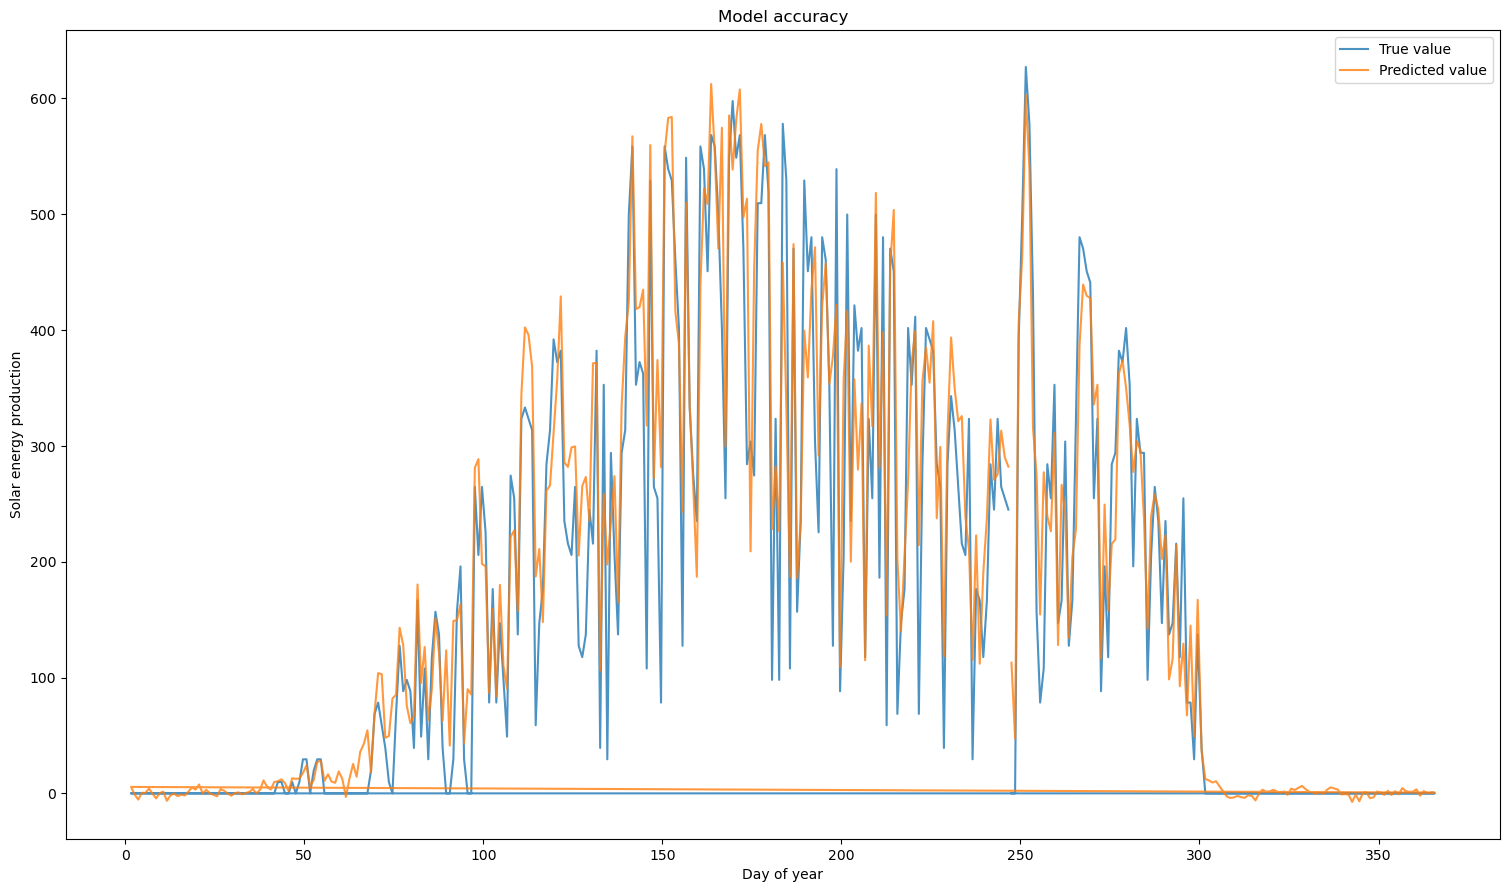

In [72]:
fig, ax = plt.subplots() # Create the figure and axes 
fig.set_size_inches(18.5, 10.5, forward=True)
plt.plot(X_train[4*4:365*24*4:24*4]['day_of_year']+(1/24)*X_train[4*4:365*24*4:24*4]['hour_of_day'], y_train[4*4:365*24*4:24*4]['pv_measurement'], alpha=0.8, label='True value', linestyle='solid')
plt.plot(X_train[4*4:365*24*4:24*4]['day_of_year']+(1/24)*X_train[4*4:365*24*4:24*4]['hour_of_day'], model.predict(X_train[4*4:365*24*4:24*4]), alpha=0.8, label='Predicted value', linestyle='solid')
plt.xlabel('Day of year')
plt.ylabel('Solar energy production')
plt.title('Model accuracy')
plt.legend()


plt.show()

In [73]:
print('Coefficients of the final estimator:')
pd.DataFrame(model.final_estimator_.coef_, model.named_estimators_.keys())

Coefficients of the final estimator:


,0
Random Forest,0.045709
Lasso,-0.433000
Gradient Boosting,0.743400
Linear Regression,0.629035
Adaboost,0.014400


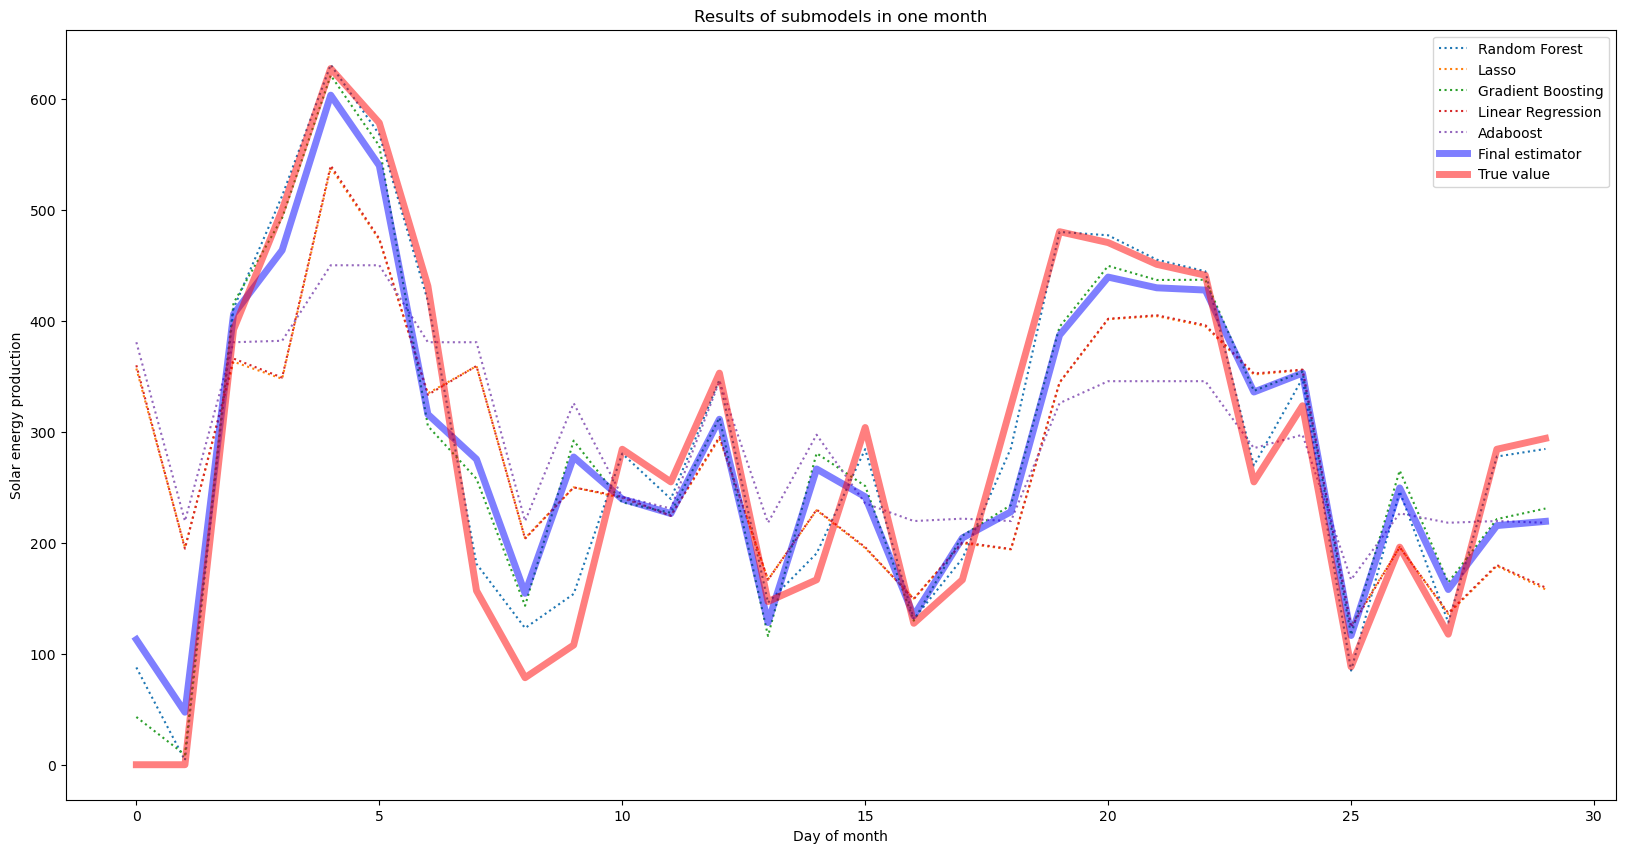

In [74]:
fig = plt.figure(figsize=(20,10))
plt.plot(model.transform(X_train)[4*4:30*4*24:24*4], label=model.named_estimators_.keys (), linestyle='dotted')
plt.plot(np.array(model.predict(X_train)[4*4:30*4*24:24*4]), label='Final estimator', linewidth=5, color='b', alpha=0.5)
plt.plot(np.array(y_train['pv_measurement'])[4*4:30*4*24:24*4], label='True value', linewidth=5, color='r', alpha=0.5)
plt.legend()
plt.title('Results of submodels in one month')
plt.xlabel('Day of month')
plt.ylabel('Solar energy production')
plt.show()